In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import sys
import torch
import time
import datetime

from torchvision import transforms
from PIL import Image
from moviepy.editor import *

%matplotlib inline

In [4]:
!nvidia-smi

Wed Oct 18 11:50:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 38%   29C    P8              13W / 320W |   1040MiB / 16376MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
YOLO_DIR = 'yolov7'
if not os.path.exists(YOLO_DIR):
    print("Starting to clone the YoloV7 repo\n")
    !git clone https://github.com/WongKinYiu/yolov7.git
    print("\nDone")

if os.path.exists(YOLO_DIR):
    print("\nDirectory is present:\n")
    !ls yolov7

Starting to clone the YoloV7 repo

'yolov7'에 복제합니다...
remote: Enumerating objects: 1191, done.
remote: Total 1191 (delta 0), reused 0 (delta 0), pack-reused 1191
오브젝트를 받는 중: 100% (1191/1191), 74.22 MiB | 16.22 MiB/s, 완료.
델타를 알아내는 중: 100% (515/515), 완료.

Done

Directory is present:

LICENSE.md  deploy     hubconf.py  requirements.txt  train.py
README.md   detect.py  inference   scripts	     train_aux.py
cfg	    export.py  models	   test.py	     utils
data	    figure     paper	   tools


In [6]:
RESULTS_DIR = 'results'

if not os.path.exists(RESULTS_DIR):
    print("Creating the directory:", RESULTS_DIR)
    os.mkdir(RESULTS_DIR)
    print("Done")

Creating the directory: results
Done


In [7]:
YOLOV7_MODEL = [
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt",
]

In [8]:
def get_yolov7_model(modelistid=1):
    """
    Download YoloV7 model from a yoloV7 model list
    """
    modelid = YOLOV7_MODEL[modelistid]

    if not os.path.exists(modelid):
        print("Downloading the model:",
              os.path.basename(modelid), "from:", modelid)
        urllib.request.urlretrieve(modelid, 
                                   filename=os.path.basename(modelid))
        print("Done\n")
        !ls yolo*.pt -lh

    if os.path.exists(modelid):
        print("Downloaded model files:")
        !ls yolo*.pt -lh

In [9]:
os.chdir(YOLO_DIR)

In [14]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
def image_view(imagefile, w=15, h=10):
    """
    Displaying an image from an image file
    """
    %matplotlib inline
    plt.figure(figsize=(w, h))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread(imagefile), cv2.COLOR_BGR2RGB))

In [17]:
def loading_yolov7_model(yolomodel):
    """
    Loading yolov7 model
    """
    print("Loading model:", yolomodel)
    model = torch.load(yolomodel, map_location=device)['model']
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)

    return model, yolomodel

In [18]:
def running_inference(image):
    """
    Running yolov7 model inference
    """
    image = letterbox(image, 960, 
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model(image)

    return output, image

In [19]:
def draw_keypoints(output, image, confidence=0.25, threshold=0.65):
    """
    Draw YoloV7 pose keypoints
    """
    output = non_max_suppression_kpt(
        output,
        confidence,  # Confidence Threshold
        threshold,  # IoU Threshold
        nc=model.yaml['nc'],  # Number of Classes
        nkpt=model.yaml['nkpt'],  # Number of Keypoints
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)

    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    return nimg

In [21]:
YOLOV7_MODEL[0]
get_yolov7_model(0)

Done

-rw-rw-r-- 1 iae iae 13M 10월 18 12:27 yolov7-tiny.pt


In [22]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[0])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-tiny.pt
Using the yolov7-tiny.pt model
Done


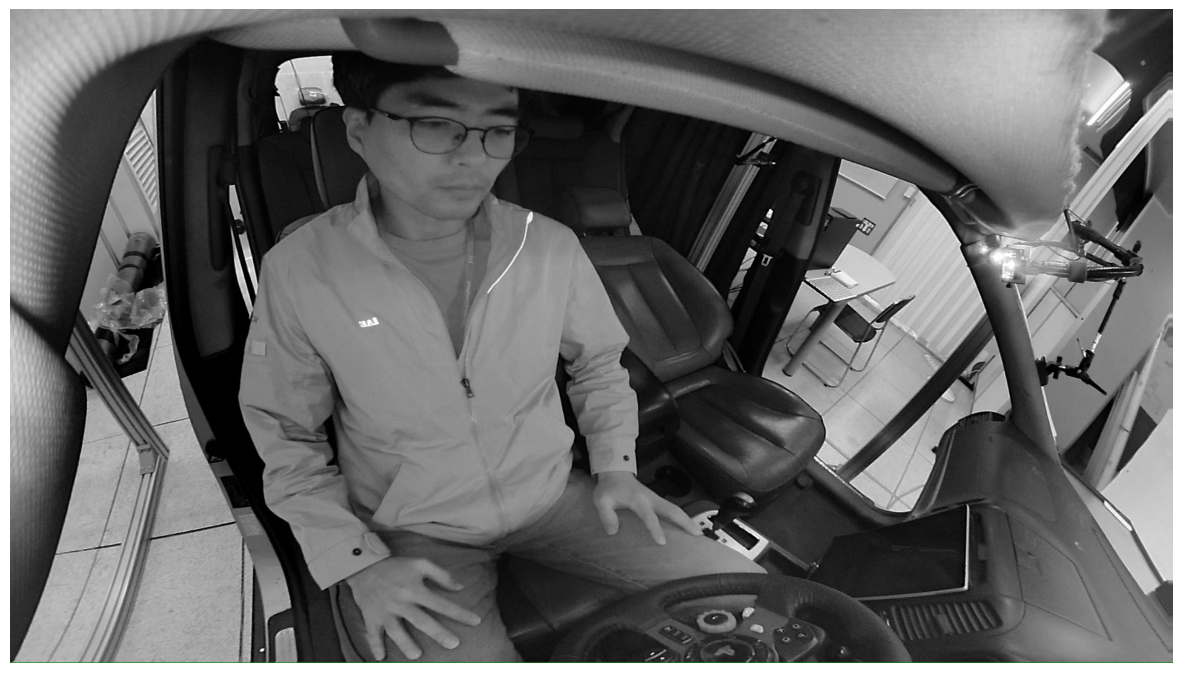

In [43]:
image_view("../../../images/test3.png")

In [33]:
!python detect.py --weights ./yolov7-tiny.pt --conf 0.2 --img-si ze 1920 --source ../../../images/test1.png

Namespace(weights=['./yolov7-tiny.pt'], source='../../../images/test1.png', img_size=1920, conf_thres=0.2, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-126-g84932d7 torch 2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16079.125MB)

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/home/iae/dev/flame-aoas-model/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
1 person, 1 airplane, 1 book, Done. (3.3ms) Inference, (190.8ms) NMS
 The imag

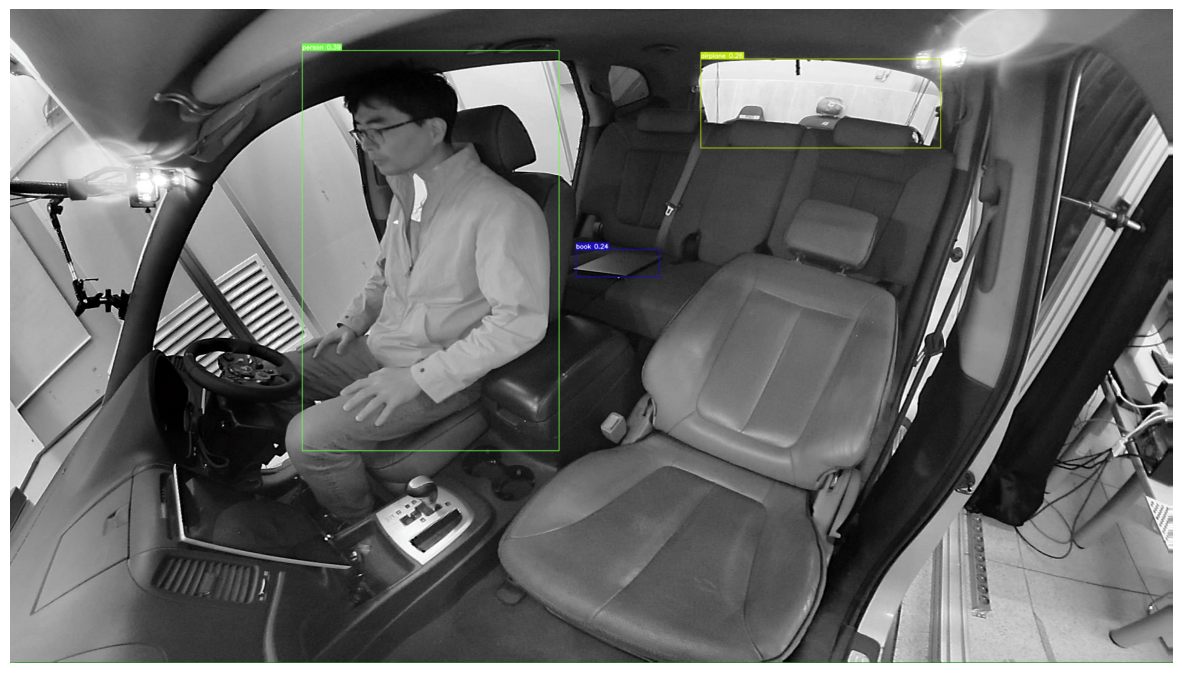

In [35]:
image_view("runs/detect/exp3/test1.png")

In [51]:
get_yolov7_model(1)

Done

-rw-rw-r-- 1 iae iae 256M 10월 18 13:21 yolov7-d6.pt
-rw-rw-r-- 1 iae iae 187M 10월 18 13:21 yolov7-e6.pt
-rw-rw-r-- 1 iae iae 291M 10월 18 13:22 yolov7-e6e.pt
-rw-rw-r-- 1 iae iae  13M 10월 18 12:27 yolov7-tiny.pt
-rw-rw-r-- 1 iae iae 154M 10월 18 12:59 yolov7-w6-pose.pt
-rw-rw-r-- 1 iae iae 135M 10월 18 13:20 yolov7-w6.pt
-rw-rw-r-- 1 iae iae  73M 10월 18 13:22 yolov7.pt
-rw-rw-r-- 1 iae iae 137M 10월 18 13:20 yolov7x.pt


Loading the model...
Loading model: yolov7-w6-pose.pt
Using the yolov7-w6-pose.pt model
Done
Elapsed time (us) : 46300


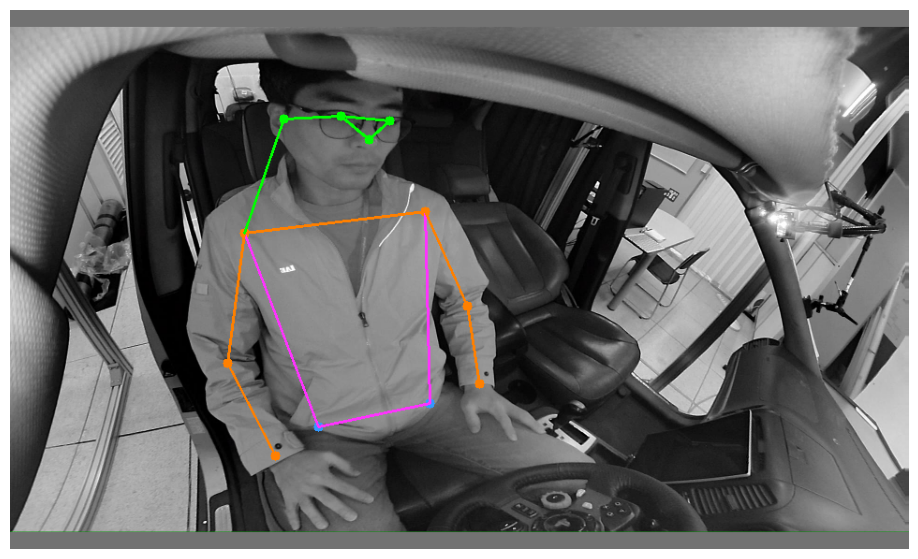

In [64]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[7])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

imagefile = "../../../images/test3.png"

#inference time check
start = datetime.datetime.now()
output, image = running_inference(cv2.imread(imagefile))
end = datetime.datetime.now()
print(f"Elapsed time (us) : {(end-start).microseconds}")
pose_image = draw_keypoints(output, image, confidence=0.25, threshold=0.65)

plt.figure(figsize=(30, 7))
plt.axis("off")
plt.imshow(pose_image)

In [54]:
!python detect.py --weights ./yolov7-w6-pose.pt --conf 0.2 --img-size 1280 --source ../../../images/test1.png

Namespace(weights=['./yolov7-w6-pose.pt'], source='../../../images/test1.png', img_size=1280, conf_thres=0.2, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-126-g84932d7 torch 2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16079.125MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 441076 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/home/iae/dev/flame-aoas-model/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Traceback (most recent call last):
  File "/home/iae/dev/flame-aoas-model/